# AML flow cytometry analysis

In [17]:
import numpy as np
import torch
from torch.autograd import Variable
from fcvae_dataset import load_data
from fcvae_model import multiVAE, multiEncoder, Decoder, Classifier
from fcvae_trainer import fcTrainer
from fcvae_plot import CellPlotter2D, plot_joint_aml, plot_shared_markers_aml, plot_imputed_values_set
from umap import UMAP
import flowkit as fk
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("Device:", device)

Torch version: 1.2.0
Device: cpu


## 1. Load data

In [18]:
filepath1 = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/data_files/"

batch_size = 256         # number of data points in each batch
n_epochs = 20           # times to run the model on complete data
input_dim = 7     # size of each input
hidden_dim = 128        # hidden dimension
latent_dim = 4        # latent vector dimension
lr = 1e-3              # learning rate
n_head = 2
n_shared = 3
n_unique = 4
missing = 4

datasets = load_data(filepath1)

input_dim_list = []
output_dim_list = []
train_iterators = []
test_iterators = []
train_cells = 0
test_cells = 0
for tube in datasets:
    input_dim_list.append(len(tube[0].columns))
    output_dim_list.append(len(tube[0].columns)+missing)
    train_iterators.append(tube[3])
    test_iterators.append(tube[4])
    train_cells += tube[1].nb_cells
    test_cells += tube[2].nb_cells

input_dim_list.append(n_shared)    
    
N_train = int(train_cells/n_head)
N_test = int(test_cells/n_head)
print('Training set size:', N_train)
print('Test set size:', N_test)

Training set size: 27000
Test set size: 3000


## 2. Create a model

In [19]:
# Encoder
encoder = multiEncoder(n_head, n_shared, n_unique, hidden_dim, latent_dim)

# Decoder
decoder = Decoder(latent_dim, hidden_dim, output_dim_list, n_head)

# VAE
model = multiVAE(encoder, decoder).to(device)

# Discriminator
discriminator = Classifier(latent_dim, hidden_dim, n_head) 

print("n_tubes:", n_head)
print("n_shared:", n_shared)
print("n_other:", missing)
print("output_dim:", output_dim_list[0])
print("encoder_dims:", input_dim_list)

n_tubes: 2
n_shared: 3
n_other: 4
output_dim: 11
encoder_dims: [7, 7, 3]


## 3. Train the model

In [20]:
# Create trainer
trainer = fcTrainer(
            model,
            discriminator,
            train_loaders = train_iterators,
            test_loaders = test_iterators,
            N_train = N_train,
            N_test = N_test,
            dloss_weight = 50,
            device = device,
            n_epochs = n_epochs,
            print_frequency = 1,
            optimizer_kwargs = dict(lr = lr)
)

06/03/2020 17:13:55 [INFO]: Creating a trainer on device `cpu`


In [21]:
# Run training
trainer.train()

06/03/2020 17:13:56 [INFO]: TRAINING STARTED (n_epochs = 20).
06/03/2020 17:14:09 [INFO]: Epoch: 00, VAE loss: (65.48112, 20.53826), Discriminator loss: (0.64987, 1.08124)
06/03/2020 17:14:22 [INFO]: Epoch: 01, VAE loss: (23.4592, 17.98289), Discriminator loss: (0.69268, 1.04481)
06/03/2020 17:14:35 [INFO]: Epoch: 02, VAE loss: (21.16072, 15.89115), Discriminator loss: (0.73798, 1.04544)
06/03/2020 17:14:48 [INFO]: Epoch: 03, VAE loss: (19.90571, 15.44042), Discriminator loss: (0.78372, 1.06568)
06/03/2020 17:15:01 [INFO]: Epoch: 04, VAE loss: (19.02225, 14.33246), Discriminator loss: (0.83836, 1.04729)
06/03/2020 17:15:14 [INFO]: Epoch: 05, VAE loss: (18.45907, 13.97802), Discriminator loss: (0.84179, 1.06157)
06/03/2020 17:15:27 [INFO]: Epoch: 06, VAE loss: (17.72904, 13.56995), Discriminator loss: (0.84624, 1.05529)
06/03/2020 17:15:40 [INFO]: Epoch: 07, VAE loss: (17.43104, 14.16443), Discriminator loss: (0.84706, 1.06789)
06/03/2020 17:15:53 [INFO]: Epoch: 08, VAE loss: (17.04101,

## 4. Visualization

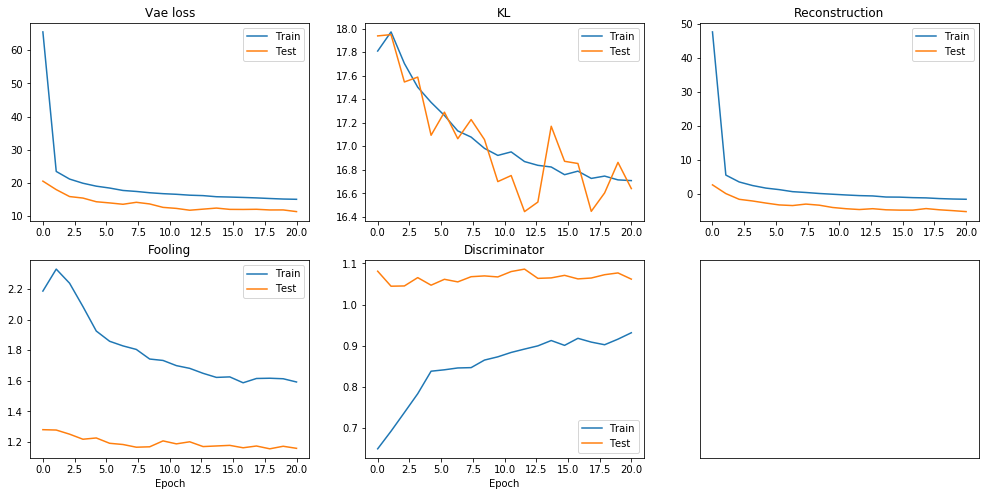

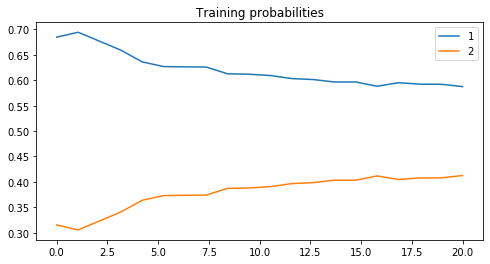

In [22]:
trainer.plot()
trainer.plot_probs()
# no test curves?

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


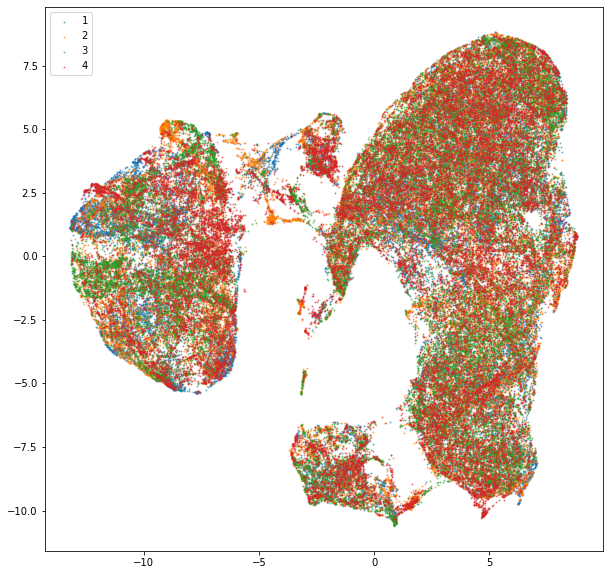

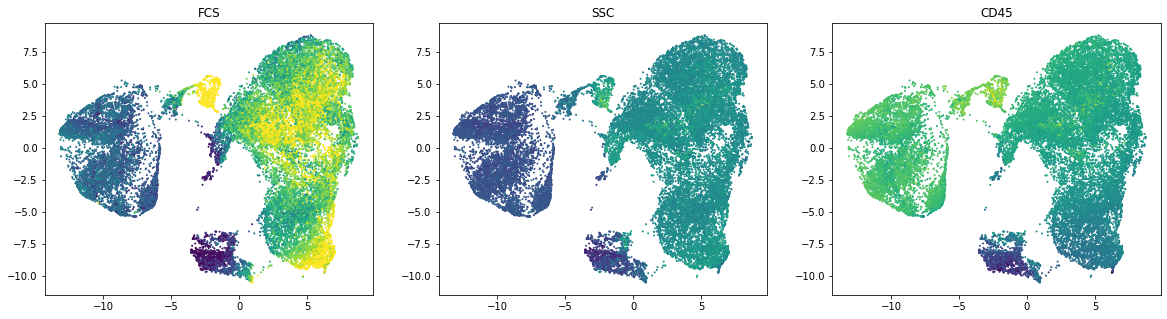

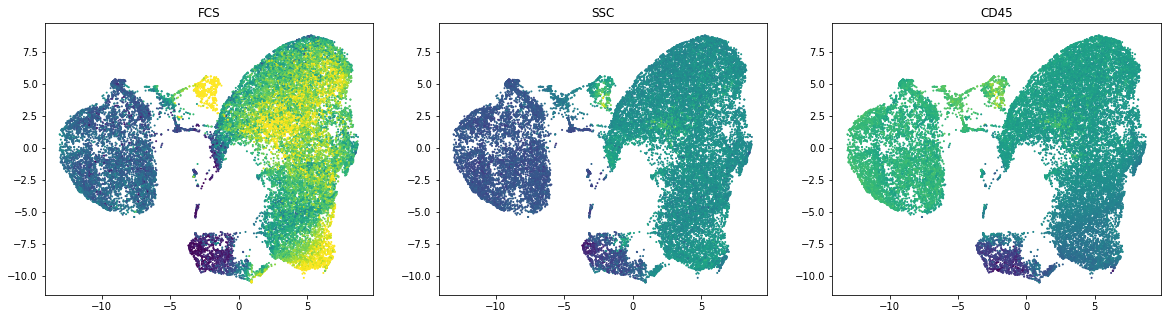

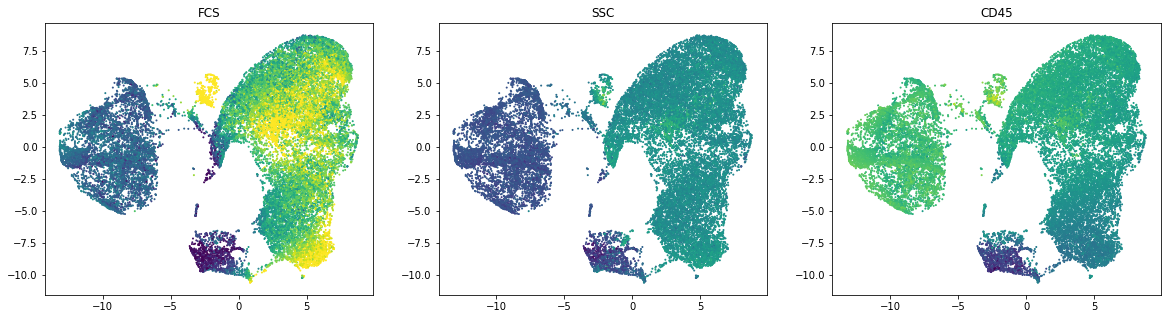

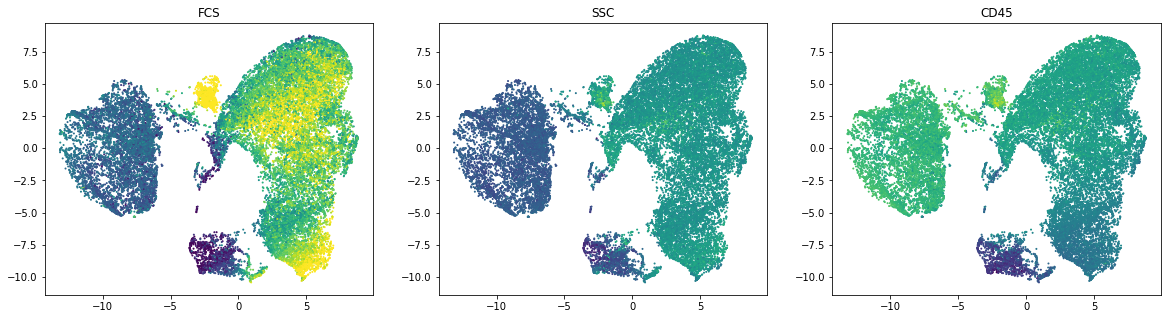

In [12]:
latents = []

trainer.vae.eval()
for i in range(n_head):
    data = Variable(torch.from_numpy(datasets[i][0].to_numpy()), requires_grad=False)
    latents.append(model.get_z(data.float(), i).data.numpy())
latent2d = UMAP().fit_transform(np.concatenate(latents))

plot_joint_aml(trainer, latent2d, latents)
plot_shared_markers_aml(trainer, latent2d, latents, datasets)

## 5. Imputation

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/flowio/flowdata.py:275: UserWarning: text in segment does not start and end with delimiter
  warn("text in segment does not start and end with delimiter")


[['CD15-FITC', 'CD13-PE', 'CD16-PC5', 'CD56-PC7'], ['CD5-FITC', 'CD19-PE', 'CD3-PC5', 'CD10-PC7'], ['CD14-FITC', 'CD11c-PE', 'CD64-PC5', 'CD33-PC7'], ['HLA-DR-FITC', 'CD117-PE', 'CD34-PC5', 'CD38-PC7']]


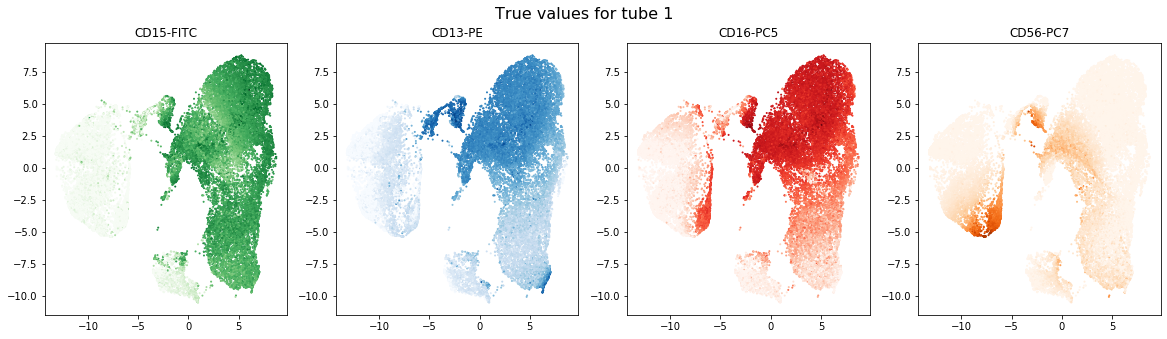

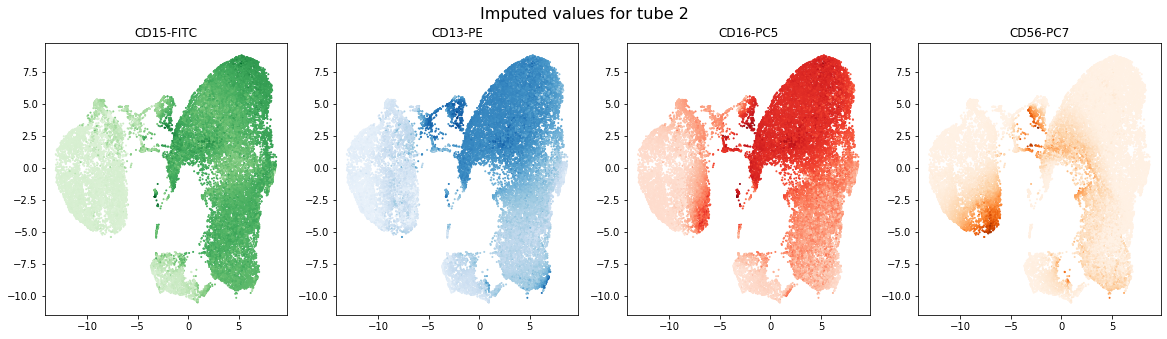

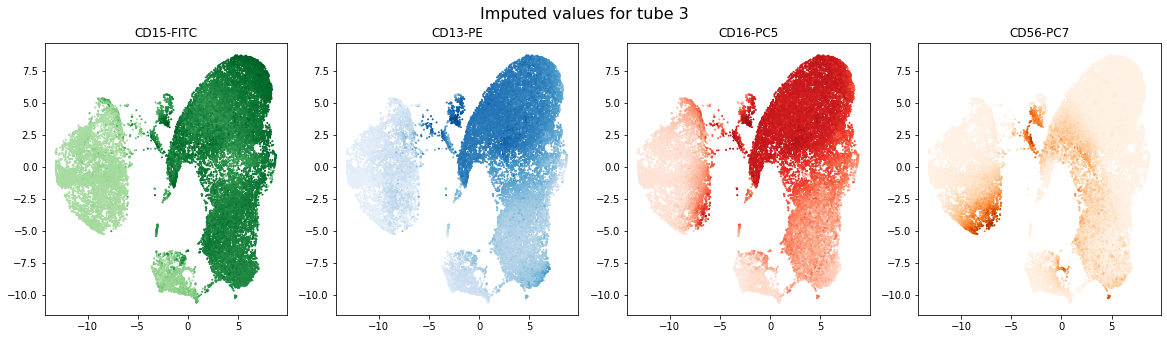

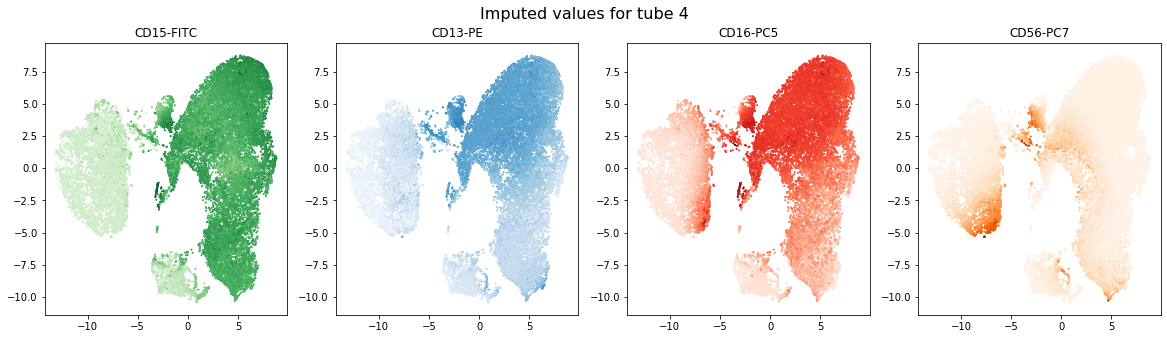

In [13]:
# marker names 
files = glob.glob(filepath1 + "*.txt")
titles = []
for i in range(len(files)):
    fcs = files[i][-8:-4]
    fcs_path = '/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Data/AML/FCS/'+fcs+'.FCS'
    sample = fk.Sample(fcs_path, subsample_count=None)
    features = sample.pns_labels[2:7]
    features.pop(2)
    titles.append(features)
print(titles) 

# visualize one set of imputed values, change later
#plot_imputed_values(trainer, latent2d, latents, datasets, titles)
tube_id = 0
plot_imputed_values_set(trainer, tube_id, latent2d, latents, datasets, titles[tube_id])

## 6. Validation metrics

In [9]:
# Comparison: accuracy and log p(y)?

def validation_accuracy(model, discriminator, test_iterators):
    model.eval()
    discriminator.eval()
    probs = []
    for tensors in test_iterators:
        ps = []
        for head_id, batch in enumerate(tensors):
            z = model.get_z(batch.float(), head_id)
            p = discriminator.classify(z)
            ps.append(p)
        pr = torch.cat(ps).cpu().detach().numpy()
        probs.append(pr)
    return probs

def validation_loss(test_iterators, model, input_dim_list):
    # set the evaluation mode
    model.eval()
    n_head = len(input_dim_list)
    # test loss for the data
    test_losses = []
    
    for tensors in test_iterators:
        for head_id, x in enumerate(tensors): 
            # reshape the data
            x = x.view(-1, input_dim_list[head_id]) 
            x = x.float()
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x, head_id)

            loss, recs, kls = model.loss(x_sample, x, z_mu, z_var, head_id)
            test_losses.append(loss)
    sum_loss = torch.stack(test_losses).sum()

    return sum_loss

runs = 5
accuracies = []
val_losses = []
for i in range(runs):
    trainer.train()
    acc = validation_accuracy(model, discriminator, zip(*test_iterators))
    acc = [item for sublist in acc for item in sublist]
    acc = [item for sublist in acc for item in sublist]
    correct = 0
    probs1 = acc[::n_head]
    for i in probs1[:N_test]:
        if i > 1/n_head:
            correct += 1
    for i in probs1[N_test:]:
        if i < 1/n_head:
            correct += 1

    accuracy = correct/len(acc[::n_head])
    accuracies.append(accuracy)
    val_loss = validation_loss(zip(*test_iterators), model, input_dim_list)/N_test
    val_losses.append(val_loss)
print(accuracies)
print(val_losses)

05/03/2020 16:21:50 [INFO]: TRAINING STARTED (n_epochs = 20).
05/03/2020 16:22:05 [INFO]: Epoch: 00, VAE loss: (14.69539, 53.53969), Discriminator loss: (0.14106, 0.21244)
05/03/2020 16:22:21 [INFO]: Epoch: 01, VAE loss: (14.91793, 56.14806), Discriminator loss: (0.13804, 0.21658)
05/03/2020 16:22:36 [INFO]: Epoch: 02, VAE loss: (14.73808, 52.50716), Discriminator loss: (0.1323, 0.2142)
05/03/2020 16:22:51 [INFO]: Epoch: 03, VAE loss: (14.77768, 51.6382), Discriminator loss: (0.13447, 0.215)
05/03/2020 16:23:06 [INFO]: Epoch: 04, VAE loss: (14.71131, 56.18731), Discriminator loss: (0.14064, 0.21941)
05/03/2020 16:23:21 [INFO]: Epoch: 05, VAE loss: (14.76837, 55.6696), Discriminator loss: (0.12994, 0.21401)
05/03/2020 16:23:36 [INFO]: Epoch: 06, VAE loss: (14.702, 54.27815), Discriminator loss: (0.13424, 0.2075)
05/03/2020 16:23:51 [INFO]: Epoch: 07, VAE loss: (14.58581, 52.67349), Discriminator loss: (0.13525, 0.21366)
05/03/2020 16:24:07 [INFO]: Epoch: 08, VAE loss: (14.57868, 53.5473

05/03/2020 16:41:15 [INFO]: Epoch: 12, VAE loss: (13.79459, 50.22748), Discriminator loss: (0.14143, 0.20657)
05/03/2020 16:41:30 [INFO]: Epoch: 13, VAE loss: (13.7921, 52.42924), Discriminator loss: (0.13894, 0.22764)
05/03/2020 16:41:46 [INFO]: Epoch: 14, VAE loss: (13.75285, 50.07374), Discriminator loss: (0.14646, 0.21207)
05/03/2020 16:42:02 [INFO]: Epoch: 15, VAE loss: (13.81958, 49.95997), Discriminator loss: (0.14265, 0.21391)
05/03/2020 16:42:18 [INFO]: Epoch: 16, VAE loss: (13.78952, 51.67304), Discriminator loss: (0.13913, 0.21297)
05/03/2020 16:42:36 [INFO]: Epoch: 17, VAE loss: (13.83414, 53.05039), Discriminator loss: (0.14018, 0.21758)
05/03/2020 16:42:51 [INFO]: Epoch: 18, VAE loss: (13.8011, 50.01506), Discriminator loss: (0.13965, 0.22742)
05/03/2020 16:43:06 [INFO]: Epoch: 19, VAE loss: (13.75074, 50.62989), Discriminator loss: (0.13949, 0.22457)
05/03/2020 16:43:06 [INFO]: TRAINING FINISHED.

05/03/2020 16:43:06 [INFO]: TRAINING STARTED (n_epochs = 20).
05/03/2020 1

In [10]:
print(np.mean(accuracies))
print(torch.mean(torch.stack(val_losses)))

0.49870000000000003
tensor(50.6794, grad_fn=<MeanBackward0>)
